In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from functions import plot_formation

In [2]:
mat_file_path = './FC_data/data.mat'
mat_data = scipy.io.loadmat(mat_file_path)

In [3]:
K = int(mat_data['K'][0][0])                    # number of iterations
L = mat_data['L']                               # NxN edge weights
M = int(mat_data['M'][0][0])                    # number of edges
N = int(mat_data['N'][0][0])                    # number of agents
R = mat_data['R']                               # covariance materix
dt = float(mat_data['dt'][0][0])                # timestep
z = mat_data['z']                               # Nx2 actual positions 
z_star = mat_data['z_star']                     # Nx2 target positions

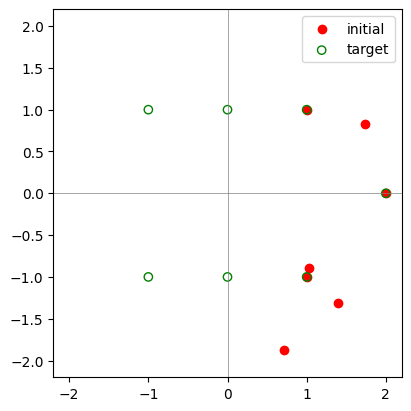

In [4]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(4,4))
ax.axvline(0, color='gray', lw=0.5)
ax.axhline(0, color='gray', lw=0.5)
ax.scatter(z[:,0], z[:,1], c='r', label='initial')
ax.scatter(z_star[:,0], z_star[:,1], c='None', edgecolors='g', label='target')
lim = 1.1*np.max(np.abs(z))
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.legend()

In [5]:
# k = 0
# while k <= K:
#     for i in range(N):
#         u = - np.sum(L[i]*(z[i] - z).T)
#         z[i] += dt*u
#         k += 1


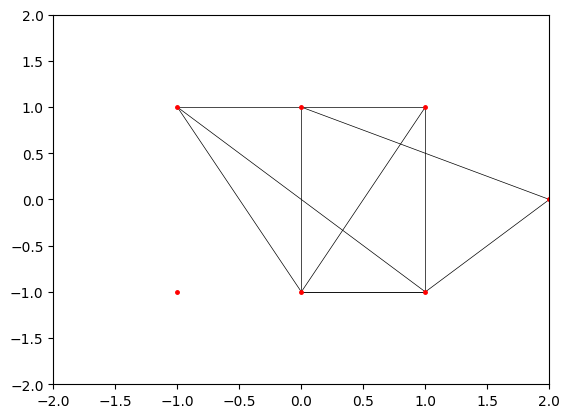

In [7]:
plot_formation(z_star)

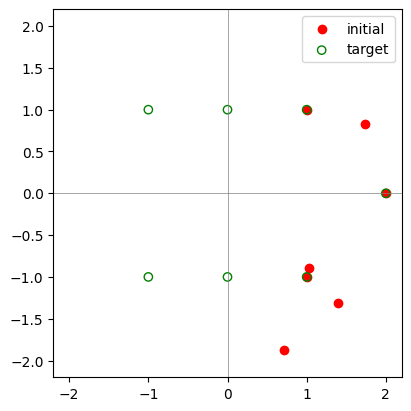

In [7]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(4,4))
ax.axvline(0, color='gray', lw=0.5)
ax.axhline(0, color='gray', lw=0.5)
ax.scatter(z[:,0], z[:,1], c='r', label='initial')
ax.scatter(z_star[:,0], z_star[:,1], c='None', edgecolors='g', label='target')
lim = 1.1*np.max(np.abs(z))
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.legend()

In [8]:
z

array([[ 2.        ,  0.        ],
       [ 1.        ,  1.        ],
       [ 1.        , -1.        ],
       [ 1.39651722, -1.31525325],
       [ 1.73597299,  0.82418435],
       [ 0.71494062, -1.87266861],
       [ 1.03096052, -0.89230806]])

In [8]:
B = np.array([[1,-1,0,0,0,0,0,0,0,-1,0,1],
            [-1,0,0,0,0,0,1,-1,0,0,0,0],
            [0,1,-1,0,0,0,0,0,1,0,0,0],
            [0,0,0,0,0,1,-1,0,0,1,-1,0],
            [0,0,1,-1,0,0,0,0,0,0,1,-1],
            [0,0,0,0,1,-1,0,0,-1,0,0,0],
            [0,0,0,1,-1,0,0,1,0,0,0,0]])


In [13]:
edges = np.where(B.flatten()!=0)[0].reshape((2,M)) % 7
edges[edges==0] = 7
edges

array([[7, 1, 2, 4, 5, 4, 5, 4, 5, 4, 6, 7],
       [3, 4, 1, 2, 2, 3, 1, 2, 5, 5, 6, 2]])

In [14]:
np.where(B!=0)[1]

array([ 0,  1,  9, 11,  0,  6,  7,  1,  2,  8,  5,  6,  9, 10,  2,  3, 10,
       11,  4,  5,  8,  3,  4,  7])